In [122]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [14]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

In [15]:
import os
import h5py
import sys
sys.path.append("../..") 
import numpy as np
#from cryoem.quaternions import euler2quaternion, d_q
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow_graphics.geometry.transformation import quaternion
from time import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)
import random
from tensorflow_graphics.math import vector
from itertools import product
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density,plot_only_selected_in_euclidean_space, plot_rays, plot_images, plot_selected_angles_with_3rd_angle_magnitude, plot_distances_count
from cryoem.angle_alignment import distance_difference
import ipyvolume as ipv
from IPython import display as IPyDisplay
import time

In [16]:
PROTEIN="5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")
      
angles_true = np.array(data['Angles'])
projections = data['Projections']      

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [17]:
ap = np.load("data/predicted_angles2.npy")

Mean `quaternion` distance between true and predicted values: 2.467 rad (141.334 degrees)
Mean `rotation matrix` distance between true and predicted values: 2.467 rad (141.334 degrees)


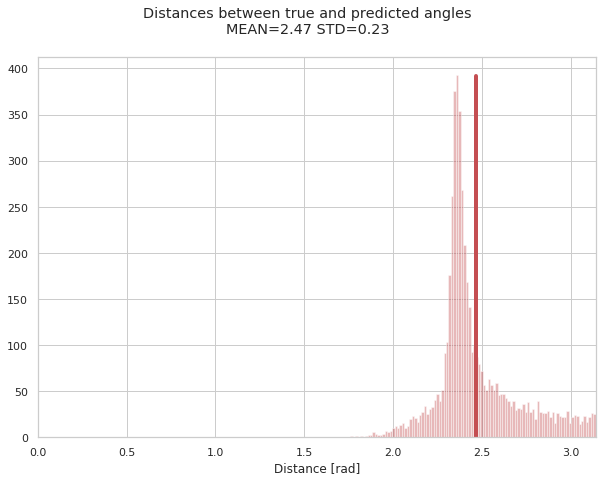

In [18]:
distance_difference(angles_predicted=ap, angles_true=angles_true);
plot_distances_count(ap, angles_true);

---

\begin{equation}
\label{eq:phase1}
\operatorname*{min}_{R  \in SO(4), m \in \{-1,1\}} \frac{1}{n} \sum_{i=1} d_r(R_i, R \begin{bmatrix}
m & 0\\
0 & I
\end{bmatrix} \hat{R_i})
\end{equation}

- $d_q$ is the distance between two quaternions

- $q_i \in S^3$ is the quaternion of a true rotation angles

- $\hat{q_i} \in S^3$ is the rotation of the estimatied rotation angles

- $R \in SO(4)$ is $4x4$ orthogonal matrix with determinant 1 that represents a global rotation

- $m \in \{-1,1\}$ represents a global reflection ($m=1$ no reflection, $m=-1$ reflection)

- $\begin{bmatrix}
m & 0\\
0 & I
\end{bmatrix} = \begin{bmatrix}
m & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{bmatrix}$

In [69]:
import numpy as np
import tensorflow as tf
from tensorflow_graphics.util import safe_ops, asserts, shape
from tensorflow_graphics.math import vector
from tensorflow_graphics.geometry.transformation import quaternion, euler
import math

def euler2matrix(angles, transposed=True):
    
    with tf.compat.v1.name_scope(None, "quaternion_from_euler", [angles]):

        angles = tf.convert_to_tensor(value=angles, dtype=tf.float64)

#         shape.check_static(tensor=angles, tensor_name="angles", has_dim_equals=(-1, 3, 3))
        
        theta_z1, theta_y, theta_z0 = tf.unstack(angles, axis=-1)

        # create rotation matrix
        c1 = tf.cos(theta_z1)
        c2 = tf.cos(theta_y)
        c3 = tf.cos(theta_z0)

        s1 = tf.sin(theta_z1)
        s2 = tf.sin(theta_y)
        s3 = tf.sin(theta_z0)

        if not transposed:
            r00 = c1*c2*c3-s1*s3
            r10 = c1*s3+c2*c3*s1
            r20 = -c3*s2
            r01 = -c3*s1-c1*c2*s3
            r11 = c1*c3-c2*s1*s3
            r21 = s2*s3
            r02 = c1*s2
            r12 = s1*s2 
            r22 = c2

        else:
            # PROJECTIONS CODE
            r00 = c1*c2*c3-s1*s3
            r01 = c1*s3+c2*c3*s1
            r02 = -c3*s2
            r10 = -c3*s1-c1*c2*s3
            r11 = c1*c3-c2*s1*s3
            r12 = s2*s3
            r20 = c1*s2
            r21 = s1*s2 
            r22 = c2

        R = tf.stack((r00, r10, r20, r01, r11, r21, r02, r12, r22), axis=-1)
        R = tf.reshape(R, (-1, 3, 3))
        
        return R

In [70]:

from tensorflow_graphics.util import safe_ops, asserts, shape
from tensorflow_graphics.math import vector
from tensorflow_graphics.geometry.transformation import quaternion, euler
import math

def d_r(M1, M2):
    """Distance between 2 rotation matirces"""
    R = tf.linalg.matmul(M1, M2, transpose_b=True)
    mid = (tf.linalg.trace(R)-1)/2

    mid = tf.cast(mid, tf.float64)
    mid = tf.clip_by_value(mid, -1, 1)
    return tf.math.acos(mid) 

In [88]:
from tensorflow_graphics.util import safe_ops, asserts, shape
from tensorflow_graphics.math import vector
from tensorflow_graphics.geometry.transformation import quaternion, euler
import math

def matrix2euler(R, transposed=True):
    """https://github.com/tensorflow/graphics/blob/master/tensorflow_graphics/geometry/transformation/euler.py"""
    
    def general_case(r02, r12, r20, r21, r22, eps_addition):
        """Handles the general case."""
        theta_y = tf.acos(r22)
        #sign_sin_theta_y = safe_ops.nonzero_sign(tf.sin(theta_y))
        
        r02 = safe_ops.nonzero_sign(r02) * eps_addition + r02
        r22 = safe_ops.nonzero_sign(r22) * eps_addition + r22
        
        theta_z0 = tf.atan2(r12, r02)
        theta_z1 = tf.atan2(r21, -r20)
        return tf.stack((theta_z0, theta_y, theta_z1), axis=-1)

    def gimbal_lock(r22, r11, r10, eps_addition):
        """Handles Gimbal locks.
        It is gimbal when r22 is -1 or 1"""
        sign_r22 = safe_ops.nonzero_sign(r22)
        r11 = safe_ops.nonzero_sign(r11) * eps_addition + r11
        
        theta_z0 = tf.atan2(sign_r22 * r10, r11)
        
        theta_y = tf.constant(math.pi/2.0, dtype=r20.dtype) - sign_r22 * tf.constant(math.pi/2.0, dtype=r20.dtype)
        theta_z1 = tf.zeros_like(theta_z0)
        angles = tf.stack((theta_z0, theta_y, theta_z1), axis=-1)
        return angles

    with tf.compat.v1.name_scope(None, "euler_from_quaternion", [R]):
        R = tf.convert_to_tensor(value=R)

#         shape.check_static(
#             tensor=R,
#             tensor_name="quaternions",
#             has_dim_equals=(-1, 3, 3))

#         x, y, z, w = tf.unstack(quaternions, axis=-1)
#         tx = safe_ops.safe_shrink(2.0 * x, -2.0, 2.0, True)
#         ty = safe_ops.safe_shrink(2.0 * y, -2.0, 2.0, True)
#         tz = safe_ops.safe_shrink(2.0 * z, -2.0, 2.0, True)
#         twx = tx * w
#         twy = ty * w
#         twz = tz * w
#         txx = tx * x
#         txy = ty * x
#         txz = tz * x
#         tyy = ty * y
#         tyz = tz * y
#         tzz = tz * z

#         # The following is clipped due to numerical instabilities that can take some
#         # enties outside the [-1;1] range.
        
#         if not transposed:
#             r00 = safe_ops.safe_shrink(1.0 - (tyy + tzz), -1.0, 1.0, True)
#             r01 = safe_ops.safe_shrink(txy - twz, -1.0, 1.0, True)
#             r02 = safe_ops.safe_shrink(txz + twy, -1.0, 1.0, True)

#             r10 = safe_ops.safe_shrink(txy + twz, -1.0, 1.0, True)
#             r11 = safe_ops.safe_shrink(1.0 - (txx + tzz), -1.0, 1.0, True)
#             r12 = safe_ops.safe_shrink(tyz - twx, -1.0, 1.0, True)

#             r20 = safe_ops.safe_shrink(txz - twy, -1.0, 1.0, True)
#             r21 = safe_ops.safe_shrink(tyz + twx, -1.0, 1.0, True)
#             r22 = safe_ops.safe_shrink(1.0 - (txx + tyy), -1.0, 1.0, True)
        
#         else:
#             r00 = safe_ops.safe_shrink(1.0 - (tyy + tzz), -1.0, 1.0, True)
#             r01 = safe_ops.safe_shrink(txy + twz, -1.0, 1.0, True)
#             r02 = safe_ops.safe_shrink(txz - twy, -1.0, 1.0, True)

#             r10 = safe_ops.safe_shrink(txy - twz, -1.0, 1.0, True)
#             r11 = safe_ops.safe_shrink(1.0 - (txx + tzz), -1.0, 1.0, True)
#             r12 = safe_ops.safe_shrink(tyz + twx, -1.0, 1.0, True)

#             r20 = safe_ops.safe_shrink(txz + twy, -1.0, 1.0, True)
#             r21 = safe_ops.safe_shrink(tyz - twx, -1.0, 1.0, True)
#             r22 = safe_ops.safe_shrink(1.0 - (txx + tyy), -1.0, 1.0, True)
        
        R = tf.reshape(R, [-1, 9])
        if not transposed:
            r00, r10, r20, r01, r11, r21, r02, r12, r22 = tf.unstack(R, axis=-1)
            
        else:
            r00, r01, r02, r10, r11, r12, r20, r21, r22 = tf.unstack(R, axis=-1)
        
        eps_addition = asserts.select_eps_for_addition(R.dtype)
        general_solution = general_case(r02, r12, r20, r21, r22, eps_addition)
        gimbal_solution = gimbal_lock(r22, r11, r10, eps_addition)
        
        # The general solution is unstable close to the Gimbal lock, and the gimbal
        # solution is not toooff in these cases.
        # Check if r22 is 1 or -1
        is_gimbal = tf.less(tf.abs(tf.abs(r22) - 1.0), 1.0e-6)
        gimbal_mask = tf.stack((is_gimbal, is_gimbal, is_gimbal), axis=-1)
        
        return tf.compat.v1.where(gimbal_mask, gimbal_solution, general_solution)     

In [89]:
def plot_distances_count(angles_predicted, angles_true, transpose):
    sns.set(style="white", color_codes=True)
    sns.set(style="whitegrid")

    if isinstance(angles_predicted, tf.Tensor):
        angles_predicted = angles_predicted.numpy()
    
    q_true = euler2matrix(angles_true, transpose)
    q_predicted = euler2matrix(angles_predicted, transpose)
    distances = d_r(q_true, q_predicted)
    
    fig, ax = plt.subplots(figsize=(10,7))
    ax.set_xlim(0, np.pi)
#     ax.set_ylim(0, len(angles_true))
    plt.suptitle(f"Distances between true and predicted angles\nCNT={len(angles_true)} MEAN={np.mean(distances):.2f} STD={np.std(distances):.2f}")
    s = sns.distplot(distances, kde=False, bins=100, ax=ax, axlabel="Distance [rad]", color="r")
    max_count = int(max([h.get_height() for h in s.patches]))
    #ax.errorbar([np.mean(distances)]*max_count, np.arange(0, max_count, 1), xerr=np.std(distances), fmt='-o', alpha=0.5)
    ax.plot([np.mean(distances)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
    #plt.show()
    return plt

In [109]:
def euler6tomarix4d(a_R):

    xy, xz, xw, yz, yw, zw = tf.unstack(a_R, axis=-1)
    
    cxy = tf.cos(xy)
    cxz = tf.cos(xz)
    cxw = tf.cos(xw)
    cyz = tf.cos(yz)
    cyw = tf.cos(yw)
    czw = tf.cos(zw)
    
    sxy = tf.sin(xy)
    sxz = tf.sin(xz)
    sxw = tf.sin(xw)
    syz = tf.sin(yz)
    syw = tf.sin(yw)
    szw = tf.sin(zw)
    
    # Note: wasn't able to create it as simple as np.ndarrays...
    Rxy = [[  cxy,  -sxy, [0.0], [0.0]], 
           [  sxy,   cxy, [0.0], [0.0]],
           [[0.0], [0.0], [1.0], [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Rxy = tf.reshape(tf.convert_to_tensor(Rxy, dtype=tf.float64), (4, 4)) 
    
    Rxz = [[  cxz, [0.0],  -sxz, [0.0]],
           [[0.0], [1.0], [0.0], [0.0]],
           [  sxz, [0.0],   cxz, [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Rxz = tf.reshape(tf.convert_to_tensor(Rxz, dtype=tf.float64), (4, 4))
    
    Rxw = [[  cxw, [0.0], [0.0],  -sxw],
           [[0.0], [1.0], [0.0], [0.0]],
           [[0.0], [0.0], [1.0], [0.0]], 
           [  sxw, [0.0], [0.0],  cxw]]
    Rxw = tf.reshape(tf.convert_to_tensor(Rxw, dtype=tf.float64), (4, 4))
    
    Ryz = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0],   cyz,  -syz, [0.0]],
           [[0.0],   syz,   cyz, [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Ryz = tf.reshape(tf.convert_to_tensor(Ryz, dtype=tf.float64), (4, 4))
    
    Ryw = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0],   cyw, [0.0],  -syw],
           [[0.0], [0.0], [1.0], [0.0]],
           [[0.0],   syw, [0.0],  cyw]]
    Ryw = tf.reshape(tf.convert_to_tensor(Ryw, dtype=tf.float64), (4, 4))
    
    Rzw = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0], [1.0], [0.0], [0.0]], 
           [[0.0], [0.0],   czw,  -szw],
           [[0.0], [0.0],   szw,  czw]]
    Rzw = tf.reshape(tf.convert_to_tensor(Rzw, dtype=tf.float64), (4, 4))
  
    R = Rxy @ Rxz @ Rxw @ Ryz @ Ryw @ Rzw

    # check if matrix is orthogonal: R^T @ R - I < 1e-5
    assert tf.reduce_all(tf.less_equal(tf.abs(tf.subtract(tf.transpose(R) @ R, tf.eye(4, 4, dtype=tf.float64))), 1e-5)), "Matrix R (4x4) should be orthogonal!" 
        
    return R


def update_angles(m, a_R, a_predicted, transposed=True):
    q_predicted = euler2matrix(a_predicted, transposed)  
    R = euler2matrix(a_R, transposed)
    
    I = tf.linalg.diag(tf.convert_to_tensor(m, dtype=tf.float64))

    q_predicted_rotated = R @ I @ q_predicted

    return matrix2euler(q_predicted_rotated, transposed=transposed)

def loss_alignment(m, a_R, a_predicted, a_true, transposed):
    q_true = euler2matrix(a_true, transposed)
    q_predicted = euler2matrix(a_predicted, transposed)
    
    R = euler2matrix(a_R, transposed=False)

    I = tf.linalg.diag(tf.convert_to_tensor(m, dtype=tf.float64))

    q_predicted_rotated = R @ I @ q_predicted
    
    loss = tf.reduce_mean(d_r(q_true, q_predicted_rotated))
    
    return loss


def gradient_alignment(m, a_R, a_predicted, a_true, transposed):
    with tf.GradientTape() as tape:
        loss_value = loss_alignment(m, a_R, a_predicted, a_true, transposed)
        gradient = tape.gradient(loss_value, a_R)
        
    return loss_value, gradient


def training_angle_alignment(m, steps, batch_size, projection_idx, learning_rate, angles_true, angles_predicted, transposed=True):
    optimizer = Adam(learning_rate=learning_rate)
    
    time_start = time.time()

    report = ""

    losses = np.empty(steps)
    angles_predicted = tf.convert_to_tensor(angles_predicted)

    euler = np.zeros(3, dtype=np.float32)
    a_R = [tf.Variable(euler)]

    for step in range(1, steps+1):

        # Sample some pairs.
        idx = list(np.random.choice(projection_idx, size=batch_size))

        # Compute distances between projections
        a_true      = [angles_true[i]      for i in idx]
        a_predicted = [angles_predicted[i] for i in idx]

        # Optimize by gradient descent.
        losses[step-1], gradients = gradient_alignment(m, a_R, a_predicted, a_true, transposed)
        optimizer.apply_gradients(zip(gradients, a_R))
        
        update_lr = 300
        if step>update_lr and step%update_lr==0 and losses[step-1]-losses[step-1-update_lr+100] < 0.1:
            learning_rate *= 0.1

        # Visualize progress periodically
        if step % 10 == 0:
            plt.close();
            sns.set(style="white", color_codes=True)
            sns.set(style="whitegrid")

            fig, axs = plt.subplots(1, 3, figsize=(24,7))
            
            # Distance count subplot (batches)
            ap1 = update_angles(m, a_R, a_predicted, transposed=transposed)
            d1 = d_r(euler2matrix(a_true, transposed), euler2matrix(ap1, transposed))
            axs[0].set_xlim(0, np.pi)
#             axs[0].set_ylim(0, batch_size)
            axs[0].set_title(f"BATCHES (size={len(a_predicted)}): [{step}/{steps}] Distances between true and predicted angles \nMEAN={np.mean(d1):.2e} STD={np.std(d1):.2e}")
            s = sns.distplot(d1, kde=False, bins=100, ax=axs[0], axlabel="Distance [rad]", color="r")
            max_count = int(max([h.get_height() for h in s.patches]))
            axs[0].plot([np.mean(d1)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

            # Optimization loss subplot
            axs[1].plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
            axs[1].set_xlabel('time [s]')
            axs[1].set_ylabel('loss');
            axs[1].set_title(f"Angle alignment optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")
            
            # Distance count subplot (full)
            ap2 = update_angles(m, a_R, angles_predicted, transposed=transposed)
            d2 = d_r(euler2matrix(angles_true, transposed), euler2matrix(ap2, transposed))
            axs[2].set_xlim(0, np.pi)
#             axs[2].set_ylim(0, len(angles_true))
            axs[2].set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} STD={np.std(d2):.2e}")
            s = sns.distplot(d2, kde=False, bins=100, ax=axs[2], axlabel="Distance [rad]", color="r")
            max_count = int(max([h.get_height() for h in s.patches]))
            axs[2].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

            
            IPyDisplay.clear_output(wait=True)
            IPyDisplay.display(plt.gcf())
            plt.close();
            time.sleep(1.0)
    

        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time.time() - time_start
            report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {np.mean(losses[step-steps//10:step-1]):.2e}\n'

    print(report)
    return m, a_R, np.mean(losses[-1-steps//10:-1])

In [110]:
print(angles_true[0])
e = angles_true[0]
q = euler2matrix([e])
e_new = matrix2euler([q])
e_new.numpy()

[2.74129289 0.84906729 5.48198312]


array([[ 2.74129289,  0.84906729, -0.80120219]])

In [111]:
update_angles([1,1,1], [tf.Variable([0.0,0.0,0.0])], angles_true, transposed=True)

<tf.Tensor: id=5944148, shape=(5000, 3), dtype=float64, numpy=
array([[ 2.74129289,  0.84906729, -0.80120219],
       [ 0.05198987,  0.52439503,  0.5559678 ],
       [-1.26363084,  0.17657386,  1.26418297],
       ...,
       [-0.89291281,  1.07968313, -0.54207156],
       [ 1.17188032,  0.65006988,  2.25601305],
       [ 2.54509695,  0.82837041,  2.37254411]])>

Mean `quaternion` distance between true and predicted values: 2.467 rad (141.334 degrees)
Mean `rotation matrix` distance between true and predicted values: 2.467 rad (141.334 degrees)


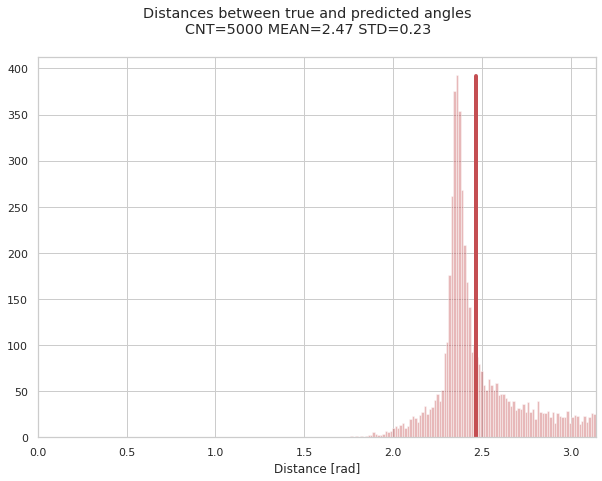

In [112]:
distance_difference(angles_predicted=ap, angles_true=angles_true);
plot_distances_count(ap, angles_true);

In [113]:
# apt = quaternion2euler(euler2quaternion(ap), transposed=False)
# distance_difference(angles_predicted=apt, angles_true=angles_true);
# plot_distances_count(apt, angles_true);

In [114]:
angles_true

array([[2.74129289, 0.84906729, 5.48198312],
       [0.05198987, 0.52439503, 0.5559678 ],
       [5.01955447, 0.17657386, 1.26418297],
       ...,
       [5.3902725 , 1.07968313, 5.74111375],
       [1.17188032, 0.65006988, 2.25601305],
       [2.54509695, 0.82837041, 2.37254411]])

In [115]:
ap

array([[ 4.76176060e+00, -9.53624185e-01,  5.83467436e+00],
       [ 6.01301573e+00, -1.65476349e-03,  3.23335063e+00],
       [ 2.03265047e+00,  3.26404737e-02,  6.61218753e+00],
       ...,
       [ 2.83409364e+00,  9.60863211e-01,  4.46866784e+00],
       [ 4.32894245e-01,  5.90500956e-01,  5.30482845e+00],
       [ 1.50417518e+00,  8.29044663e-01,  5.77571171e+00]])

In [ ]:
m, rotation, loss = training_angle_alignment(m=[1.0, 1.0, 1.0],
                         steps=300, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap,
                                            transposed=True)

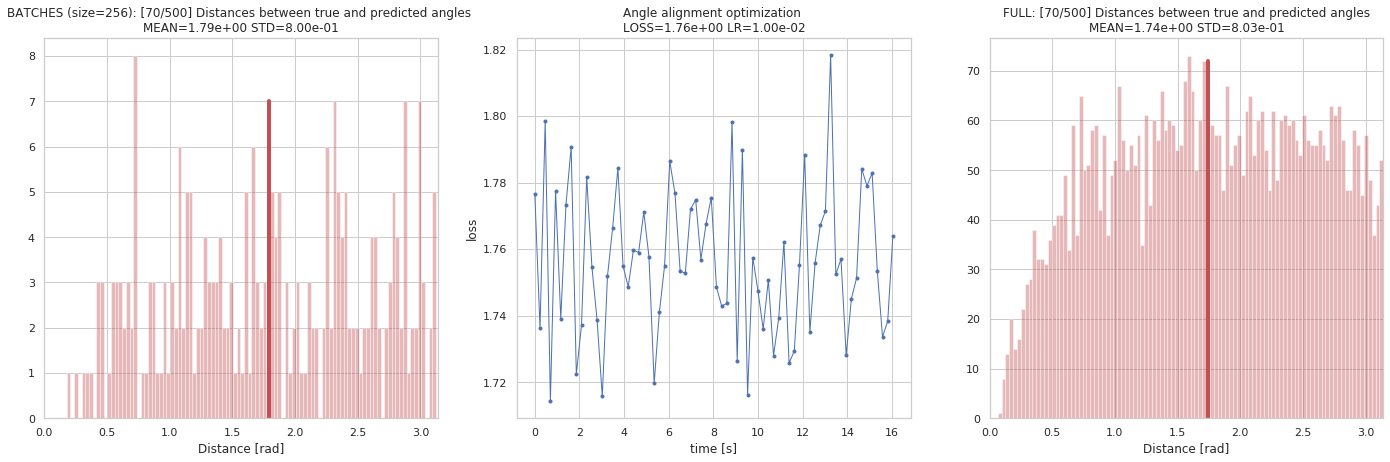

KeyboardInterrupt: 

In [117]:
m, rotation, loss = training_angle_alignment(m=[-1.0, 1.0, 1.0],
                         steps=500, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap, 
                        transposed=False)

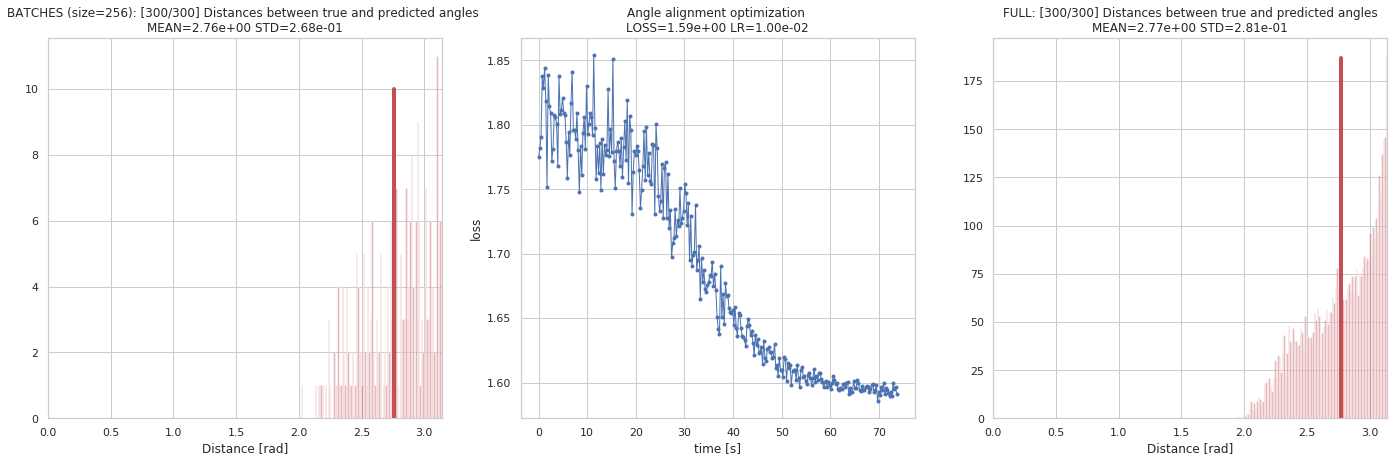

step 30/300 (8s): loss = 1.80e+00
step 60/300 (15s): loss = 1.79e+00
step 90/300 (23s): loss = 1.78e+00
step 120/300 (31s): loss = 1.75e+00
step 150/300 (38s): loss = 1.70e+00
step 180/300 (46s): loss = 1.65e+00
step 210/300 (53s): loss = 1.62e+00
step 240/300 (61s): loss = 1.60e+00
step 270/300 (68s): loss = 1.60e+00
step 300/300 (76s): loss = 1.59e+00



In [120]:
m, rotation, loss = training_angle_alignment(m=[1.0, -1.0, 1.0],
                         steps=300, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap,
                                            transposed=True)

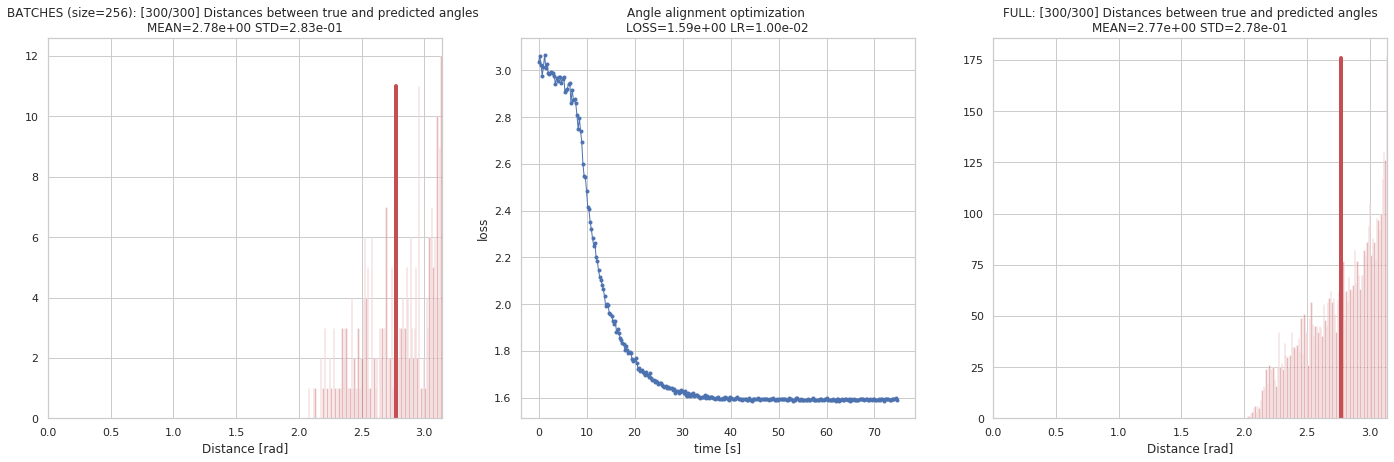

step 30/300 (7s): loss = 2.97e+00
step 60/300 (15s): loss = 2.38e+00
step 90/300 (23s): loss = 1.81e+00
step 120/300 (31s): loss = 1.66e+00
step 150/300 (38s): loss = 1.61e+00
step 180/300 (46s): loss = 1.59e+00
step 210/300 (53s): loss = 1.59e+00
step 240/300 (61s): loss = 1.59e+00
step 270/300 (69s): loss = 1.59e+00
step 300/300 (76s): loss = 1.59e+00



In [121]:
m, rotation, loss = training_angle_alignment(m=[1.0, 1.0, -1.0],
                         steps=300, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap,
                                            transposed=False)

In [ ]:
###

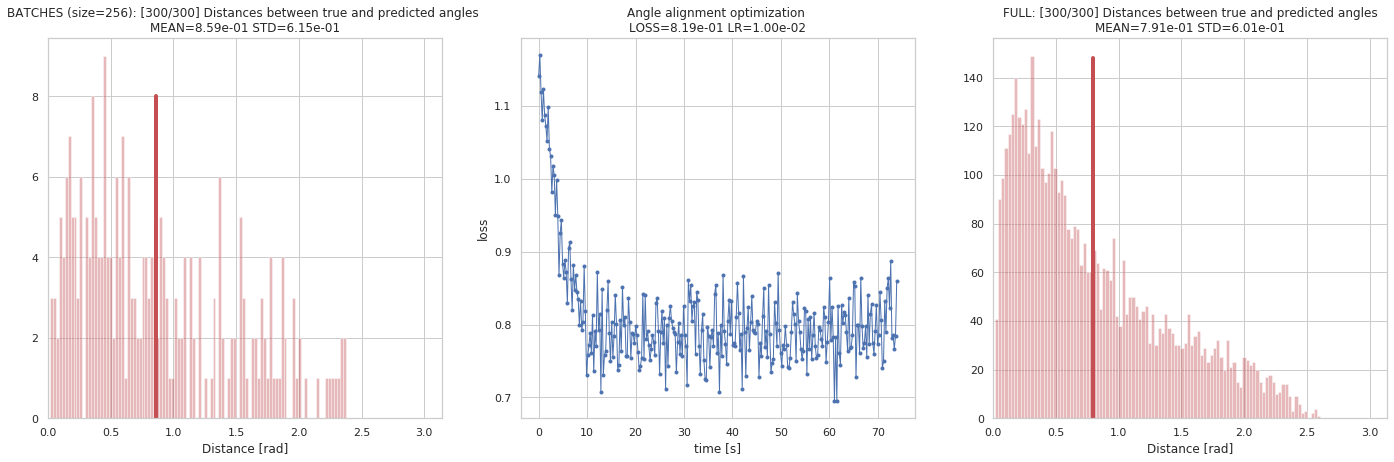

step 30/300 (7s): loss = 9.83e-01
step 60/300 (15s): loss = 8.00e-01
step 90/300 (23s): loss = 7.82e-01
step 120/300 (30s): loss = 7.83e-01
step 150/300 (38s): loss = 7.92e-01
step 180/300 (45s): loss = 7.92e-01
step 210/300 (53s): loss = 7.83e-01
step 240/300 (60s): loss = 7.87e-01
step 270/300 (68s): loss = 7.88e-01
step 300/300 (76s): loss = 7.99e-01



In [101]:
m, rotation, loss = training_angle_alignment(m=[-1.0, -1.0, 1.0],
                         steps=300, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap)

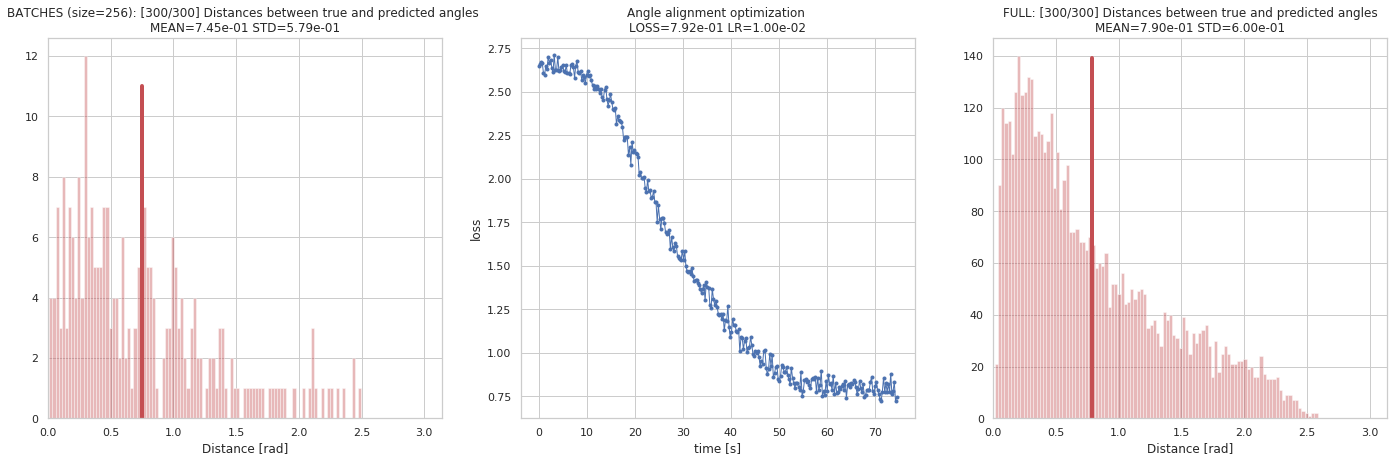

step 30/300 (8s): loss = 2.64e+00
step 60/300 (16s): loss = 2.55e+00
step 90/300 (23s): loss = 2.22e+00
step 120/300 (30s): loss = 1.75e+00
step 150/300 (38s): loss = 1.40e+00
step 180/300 (46s): loss = 1.13e+00
step 210/300 (53s): loss = 9.30e-01
step 240/300 (61s): loss = 8.25e-01
step 270/300 (69s): loss = 8.09e-01
step 300/300 (76s): loss = 7.90e-01



In [102]:
m, rotation, loss = training_angle_alignment(m=[-1.0, 1.0, -1.0],
                         steps=300, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap)

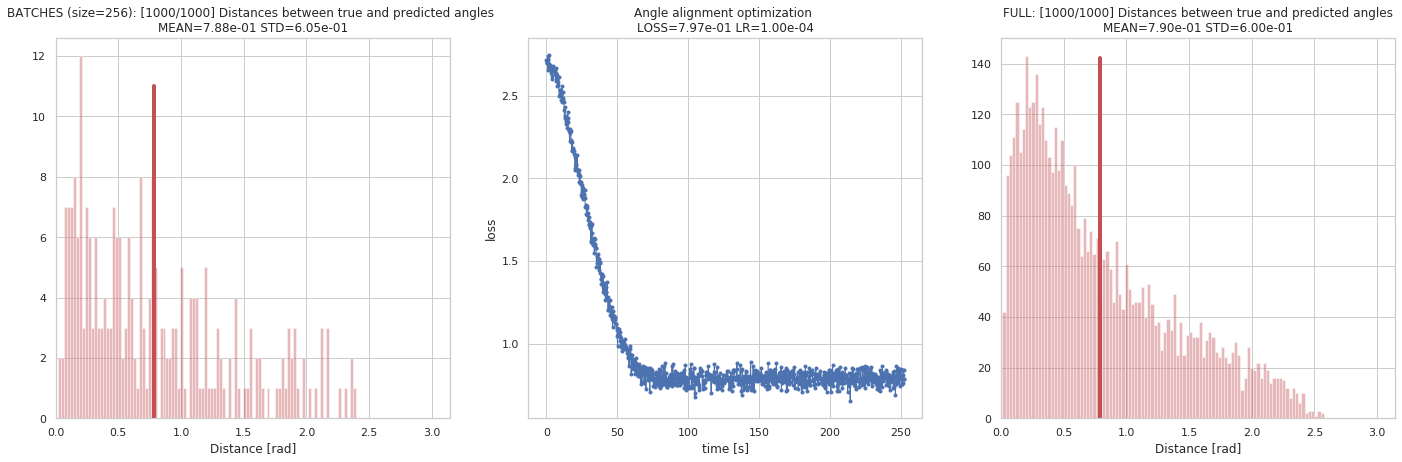

step 100/1000 (25s): loss = 2.40e+00
step 200/1000 (50s): loss = 1.47e+00
step 300/1000 (76s): loss = 8.90e-01
step 400/1000 (101s): loss = 7.85e-01
step 500/1000 (126s): loss = 7.90e-01
step 600/1000 (152s): loss = 7.90e-01
step 700/1000 (177s): loss = 7.94e-01
step 800/1000 (203s): loss = 7.89e-01
step 900/1000 (228s): loss = 7.91e-01
step 1000/1000 (254s): loss = 7.91e-01



In [105]:
m, rotation, loss = training_angle_alignment(m=[1.0, -1.0, -1.0],
                         steps=1000, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap)

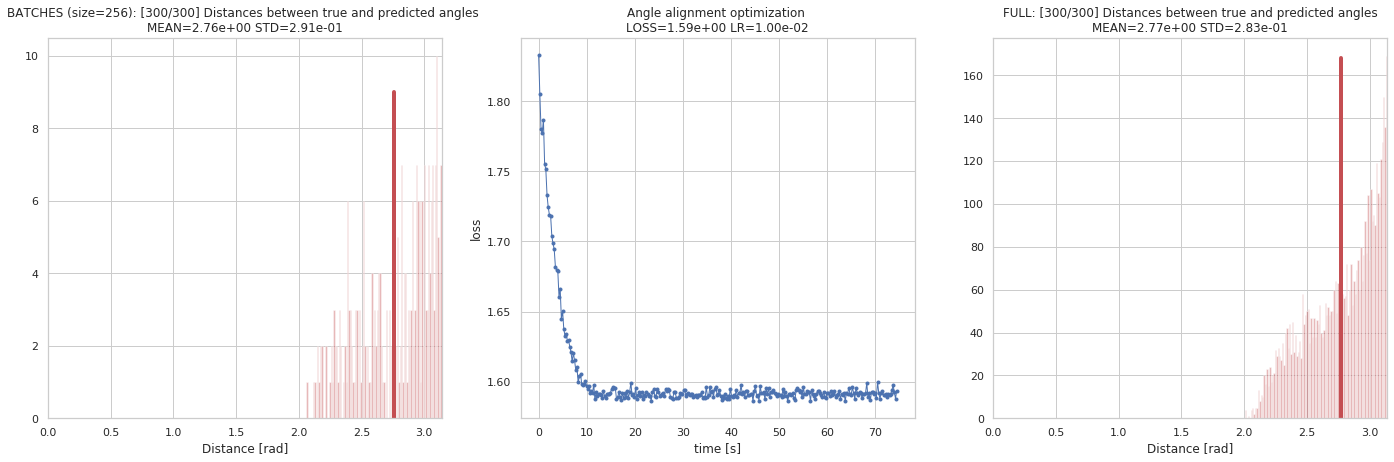

step 30/300 (8s): loss = 1.70e+00
step 60/300 (16s): loss = 1.60e+00
step 90/300 (23s): loss = 1.59e+00
step 120/300 (31s): loss = 1.59e+00
step 150/300 (38s): loss = 1.59e+00
step 180/300 (46s): loss = 1.59e+00
step 210/300 (53s): loss = 1.59e+00
step 240/300 (61s): loss = 1.59e+00
step 270/300 (69s): loss = 1.59e+00
step 300/300 (76s): loss = 1.59e+00



In [104]:
m, rotation, loss = training_angle_alignment(m=[-1.0, -1.0, -1.0],
                         steps=300, 
                         batch_size=256, 
                         projection_idx=range(NUM_PROJECTIONS), 
                         learning_rate=0.01, 
                         angles_true=angles_true, 
                         angles_predicted=ap)

In [2]:
m, rotation[0].numpy(), loss

In [3]:
mat = update_angles(m, rotation, apt)
mat

In [4]:
distance_difference(angles_predicted=mat, angles_true=angles_true);
plot_distances_count(mat, angles_true);

In [33]:
np.savez(f"../3-reconstruction/data/{PROTEIN}_projections_and_angles_var0.8_perfect_aligned", projections, mat)